# The Big Project begins!!

## The Product Pricer

A model that can estimate how much something costs, from its description.

## Data Curation Part 1

Today we'll begin our scrubbing and curating our dataset by focusing on a subset of the data: Home Appliances.

The dataset is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

And the folder with all the product datasets is here:  
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

In [1]:
# imports

import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict, Features, Value, Sequence
import matplotlib.pyplot as plt

In [2]:
# environment

load_dotenv(override=True)
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in to HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


## One more import - the Item class

If you get an error that you need to agree to Meta's terms when you run this, then follow the link it provides you and follow their instructions. You should get approved by Meta within minutes.

See the last cell in [this colab](https://colab.research.google.com/drive/1deJO03YZTXUwcq2vzxWbiBhrRuI29Vo8?usp=sharing#scrollTo=FqyF5jZQkIl_) for steps to take if Meta doesn't approve.

Any problems - message me or email me!  

With thanks to student Dr John S. for pointing out that this import needs to come after signing in to HF

In [4]:
from items import Item

In [5]:
%matplotlib inline

In [ ]:
# Load in our dataset

dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023", f"raw_meta_Appliances", split="full", trust_remote_code=True)

In [ ]:
dataset = load_dataset("Amazon-Reviews-2023/raw_meta_Electronics",  split="train", )

In [ ]:

dataset = load_dataset("json",data_files="Amazon-Reviews-2023/raw/meta_categories/meta_Appliances.jsonl" , split="train", features=features )

In [6]:
import json

#Features ({
#        'Part Number': Value('string'),
#        'Item Weight': Value('string'),
#        'Package Dimensions': Value('string'),
#        'Is Discontinued By Manufacturer': Value('string'),
#        'Batteries Included?': Value('string'),
#        'Batteries Required?': Value('string'),
#        'Date First Available': Value('string')
#    })

features = Features({
    'main_category': Value('string'),
    'title': Value('string'),
    'average_rating': Value(dtype='float64'),
    'rating_number': Value(dtype='int64'),
    'features': Sequence(Value('string')),
    'description': Sequence(Value('string')),
    'price': Value(dtype='float64'),
    'images': Sequence(Value('string')),
    'videos': Sequence(Value('string')),
    'store': Value('string'),
    'categories': Sequence(Value('string')),
    'details': Value( ('string') ),
    'parent_asin': Value('string'),
    'bought_together': Value('string')
})

file = "Amazon-Reviews-2023/raw/meta_categories/meta_Appliances.jsonl"
parsed_objects = []
with open(file, 'r') as fp:
    for line in fp:
        json_data=json.loads(line.strip())
        if 'price' in json_data and json_data['price'] is None:
            json_data['price'] = 0.0
        parsed_objects.append(json_data)

dataset = Dataset.from_list(parsed_objects, features=features )


In [7]:
print(f"Number of Appliances: {len(dataset):,}")


Number of Appliances: 94,327


In [8]:
datapoint = dataset[100]

In [ ]:
# Investigate
print(datapoint)

print(datapoint["title"])
print(datapoint["description"])
print(datapoint["features"])
print(datapoint["details"])
print(datapoint["price"])

In [ ]:
# How many have prices?

prices = 0
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices += 1
    except ValueError as e:
        pass

print(f"There are {prices:,} with prices which is {prices/len(dataset)*100:,.1f}%")

In [ ]:
# For those with prices, gather the price and the length

prices = []
lengths = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            prices.append(price)
            contents = datapoint["title"] + str(datapoint["description"]) + str(datapoint["features"]) + str(datapoint["details"])
            lengths.append(len(contents))
    except ValueError as e:
        pass

In [ ]:
# Plot the distribution of lengths

plt.figure(figsize=(15, 6))
plt.title(f"Lengths: Avg {sum(lengths)/len(lengths):,.0f} and highest {max(lengths):,}\n")
plt.xlabel('Length (chars)')
plt.ylabel('Count')
plt.hist(lengths, rwidth=0.7, color="lightblue", bins=range(0, 6000, 100))
plt.show()

In [ ]:
# Plot the distribution of prices

plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.2f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="orange", bins=range(0, 1000, 10))
plt.show()

In [ ]:
# So what is this item??

for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 21000:
            print(datapoint['title'])
    except ValueError as e:
        pass

This is the closest I can find - looks like it's going at a bargain price!!

https://www.amazon.com/TurboChef-Electric-Countertop-Microwave-Convection/dp/B01D05U9NO/

## Now it's time to curate our dataset

We select items that cost between 1 and 999 USD

We will be create Item instances, which truncate the text to fit within 180 tokens using the right Tokenizer

And will create a prompt to be used during Training.

Items will be rejected if they don't have sufficient characters.

## But why 180 tokens??

A student asked me a great question - why are we truncating to 180 tokens? How did we determine that number? (Thank you Moataz A. for the excellent question).

The answer: this is an example of a "hyper-parameter". In other words, it's basically trial and error! We want a sufficiently large number of tokens so that we have enough useful information to gauge the price. But we also want to keep the number low so that we can train efficiently. You'll see this in action in Week 7.

I started with a number that seemed reasonable, and experimented with a few variations before settling on 180. If you have time, you should do the same! You might find that you can beat my results by finding a better balance. This kind of trial-and-error might sound a bit unsatisfactory, but it's a crucial part of the data science R&D process.

There's another interesting reason why we might favor a lower number of tokens in the training data. When we eventually get to use our model at inference time, we'll want to provide new products and have it estimate a price. And we'll be using short descriptions of products - like 1-2 sentences. For best performance, we should size our training data to be similar to the inputs we will provide at inference time.

## But I see in items.py it constrains inputs to 160 tokens?

Another great question from Moataz A.! The description of the products is limited to 160 tokens because we add some more text before and after the description to turn it into a prompt. That brings it to around 180 tokens in total.



In [9]:
# Create an Item object for each with a price

items = []
for datapoint in dataset:
    try:
        price = float(datapoint["price"])
        if price > 0:
            item = Item(datapoint, price)
            if item.include:
                items.append(item)
    except ValueError as e:
        pass

print(f"There are {len(items):,} items")

There are 35,303 items


In [10]:
# Look at the first item

items[1]

<SAMSUNG Cap-Handle Sub Fre L;Nw2 (DA67-02639A) = $53.68>

In [11]:
# Investigate the prompt that will be used during training - the model learns to complete this

print(items[100].prompt)

How much does this cost to the nearest dollar?

Giantex Portable Washing Machine, Full Automatic Washer and Dryer Combo, with Built-in Pump Drain 8 LBS Capacity Compact Laundry Washer Spinner for Apartment RV Dorm
Easy & Convenient to Use Our Giantex portable full automatic laundry washing machine only needs a small space for store, which is a solution for compact living. Once you set the washing machine program, you could just leave it alone to work and do your own staffs. It could relief your hands and you could use the time to do other things. Water Level and Mode Control 6 Programs for choosing wash-rinse-spin, soak-wash-rinse -spin, wash, wash-rinse, rinse-spin, spin. With 3 water level L/16L M/23L H/30L. You could

Price is $250.00


In [ ]:
# Investigate the prompt that will be used during testing - the model has to complete this

print(items[100].test_prompt())

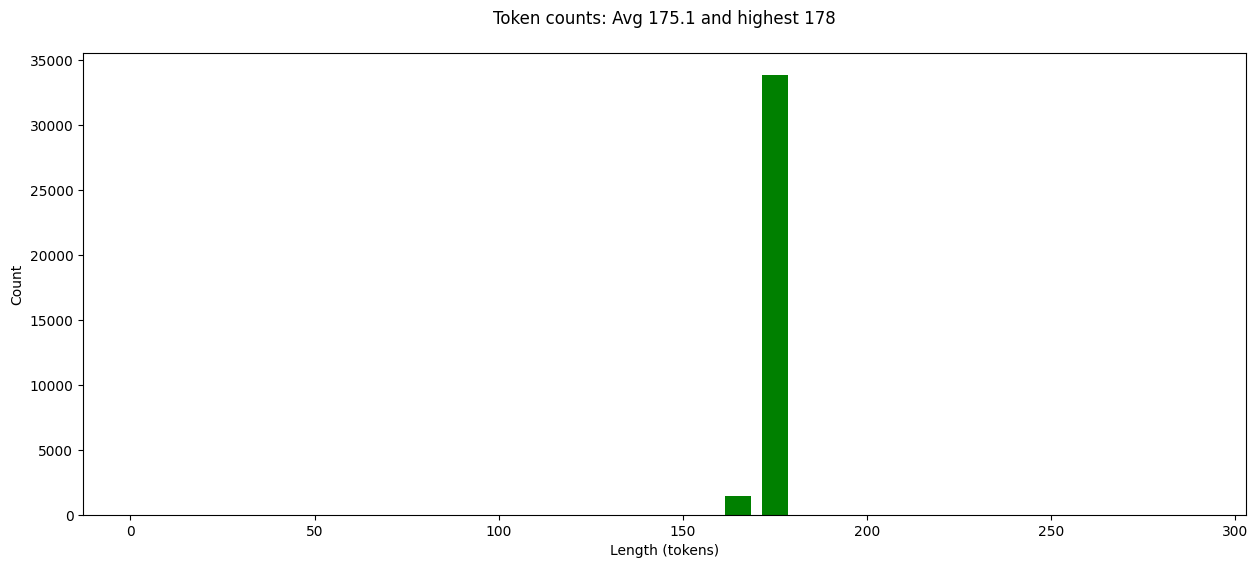

In [12]:
# Plot the distribution of token counts

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Length (tokens)')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="green", bins=range(0, 300, 10))
plt.show()

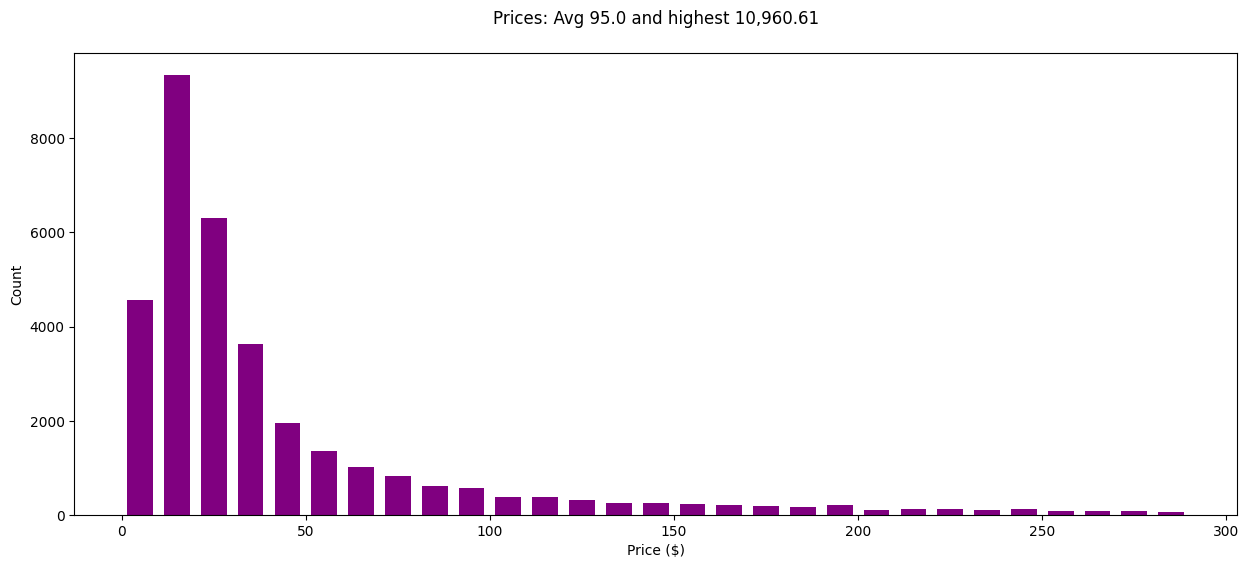

In [13]:
# Plot the distribution of prices

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="purple", bins=range(0, 300, 10))
plt.show()

## Sidenote

If you like the variety of colors that matplotlib can use in its charts, you should bookmark this:

https://matplotlib.org/stable/gallery/color/named_colors.html

## Todos for you:

- Review the Item class and check you're comfortable with it
- Examine some Item objects, look at the training prompt with `item.prompt` and test prompt with `item.test_prompt()`
- Make some more histograms to better understand the data

## Next time we will combine with many other types of product

Like Electronics and Automotive. This will give us a massive dataset, and we can then be picky about choosing a subset that will be most suitable for training.